## Create data

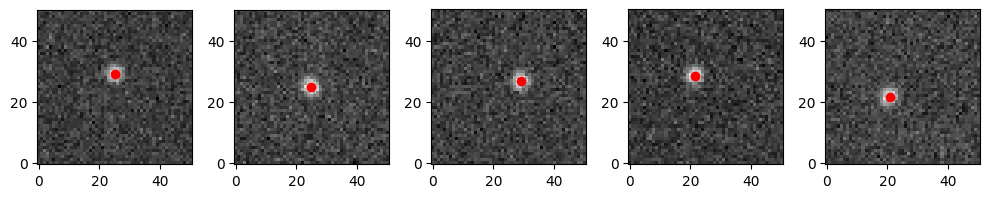

In [20]:
import deeptrack as dt 
from numpy.random import uniform
import numpy as np

image_size = 51

particle = dt.PointParticle(
    position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
)

optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size))

import torch

simulation = (
    optics(particle) 
    >> dt.NormalizeMinMax(0, 1)
    >> dt.Gaussian(sigma=0.1)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

train_dataset = dt.pytorch.Dataset(simulation & [0], length=100)
test_dataset = dt.pytorch.Dataset(simulation & particle.position, length=5000)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(5):
	image, position = test_dataset[i]
	plt.subplot(1, 5, i + 1)
	plt.imshow(image[0], cmap="gray", origin="lower")
	plt.scatter(position[1], position[0], c="r")
plt.tight_layout()
plt.show()

In [49]:
from typing import Callable, Optional

import numpy as np
import scipy
import scipy.ndimage
import torch
import torch.nn as nn
from skimage import morphology

from deeplay import ConvolutionalNeuralNetwork, Application

from deeplay.applications.detection.lodestar.transforms import (
    RandomRotation2d,
    RandomTranslation2d,
    Transforms,
)


class LodeSTAR(Application):

    # num_outputs: int # only 2D for now
    num_classes: int
    transforms: Transforms
    n_transforms: int
    model: nn.Module
    between_loss: Callable
    within_loss: Callable
    between_loss_weight: float
    within_loss_weight: float

    def __init__(
        self,
        model: Optional[nn.Module] = None,
        # num_outputs: int = 2,
        num_classes: int = 2,
        transforms: Optional[Transforms] = None,
        n_transforms: int = 2,
        between_loss: Optional[Callable] = None,
        within_loss: Optional[Callable] = None,
        between_loss_weight: float = 1,
        within_loss_weight: float = 10,
        **kwargs
    ):
        if transforms is None:
            transforms = Transforms(
                [
                    RandomTranslation2d(),
                    RandomRotation2d(),
                ]
            )

        self.num_classes = num_classes
        self.transforms = transforms
        self.n_transforms = n_transforms
        self.model = model or self._get_default_model()
        self.between_loss = between_loss or nn.L1Loss(reduction="mean")
        self.within_loss = within_loss or nn.L1Loss(reduction="mean")
        self.between_loss_weight = between_loss_weight
        self.within_loss_weight = within_loss_weight

        super().__init__(loss=None, **kwargs)

    def _get_default_model(self):
        cnn = ConvolutionalNeuralNetwork(
            None,
            [32, 32, 64, 64, 64, 64, 64, 64, 64],
            (2 + 1) + (self.num_classes + 1),  # (num_outputs + 1) + (num_classes +1)
        )
        cnn.blocks[2].pooled()

        return cnn

    def transform_data(self, batch):
        repeated = batch.repeat_interleave(self.n_transforms, dim=0)
        transformed, inverse = self.transforms(repeated)
        return transformed, inverse

    def forward(self, x):

        x = []
        class_label = []
        for data in train_dataset:
            x_values, class_labels = data
            x.append(x_values)
            class_label.append(class_labels)

        x = torch.stack(x)
        _, _, Hx, Wx = x.shape

        model_output = self.model(x)
        y = model_output[:, :3, ...]
        classes = model_output[:, 3:, ...]
        
        classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1) # This is good for one class but how do we distinguis between two classes?

        _, _, Hy, Wy = y.shape

        x_range = torch.arange(Hy, device=x.device) * Hx / Hy
        y_range = torch.arange(Wy, device=x.device) * Wx / Wy

        if self.training:
            x_range = x_range - Hx / 2 + 0.5
            y_range = y_range - Wx / 2 + 0.5

            batch_indices = torch.arange(classes.size(0))
            mask = classes[batch_indices,  class_label, :, :][:, None]

            # mask = classes[:, class_label : class_label + 1]
            # mask = classes[:,[0,class_label]].sum(dim=1, keepdim=True)
        else:
            mask = torch.ones_like(y[:, 2:3])
        Y, X = torch.meshgrid(y_range, x_range, indexing="xy")

        delta_x = y[:, 0]
        delta_y = y[:, 1]
        weights = y[:, 2].sigmoid()
        classes = y[:, 2:]

        X = X + delta_x
        Y = Y + delta_y

        return torch.cat(
            [X[:, None], Y[:, None], y[:, 2:3], weights[:, None] * mask], dim=1
        )

    def normalize(self, weights):
        weights = weights + 1e-5
        return weights / weights.sum(dim=(2, 3), keepdim=True)

    def reduce(self, X, weights):
        return (X * weights).sum(dim=(2, 3)) / weights.sum(dim=(2, 3))

    def compute_loss(self, y_hat, inverse_fn):
        B = y_hat.size(0) / self.n_transforms

        y_pred, weights = y_hat[:, :-1], y_hat[:, -1:]

        weights = self.normalize(weights)
        y_reduced = self.reduce(y_pred, weights)

        within_disagreement = (y_pred - y_reduced[..., None, None]) * weights
        within_disagreement_loss = self.within_loss(
            within_disagreement, torch.zeros_like(within_disagreement)
        )

        y_reduced_on_initial = inverse_fn(y_reduced)

        between_disagreement_loss = 0

        for i in range(0, y_pred.size(0), self.n_transforms):
            batch_preds = y_reduced_on_initial[i : i + self.n_transforms]
            batch_mean_pred = batch_preds.mean(dim=0, keepdim=True).expand_as(
                batch_preds
            )
            between_disagreement_loss += (
                self.between_loss(batch_preds, batch_mean_pred) / B
            )

        weighted_between_loss = between_disagreement_loss * self.between_loss_weight
        weighted_within_loss = within_disagreement_loss * self.within_loss_weight

        return {
            "between_image_disagreement": weighted_between_loss,
            "within_image_disagreement": weighted_within_loss,
        }

    def detect(self, x, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"):
        """Detects objects in a batch of images

        Parameters
        ----------
        x : array-like
            Input to model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        y, classes = self(x.to(self.device))
        y_pred, weights = y[:, :-1], y[:, -1:]
        detections = [
            self.detect_single(y_pred[i], weights[i], alpha, beta, cutoff, mode)
            for i in range(len(y_pred))
        ]

        return detections

    def pooled(self, x, mask=1):
        """Pooled output from model.

        Predict and pool the output from the model. Useful to acquire a single output from the model.
        Masking is supported by setting the mask to 0 where the output should be ignored.

        Parameters
        ----------
        x : array-like
            Input to model
        mask : array-like
            Mask for pooling. Should be the same shape as the output from the model with a single channel.
        """
        y, classes = self(x.to(self.device))
        y_pred, weights = y[:, :-1], y[:, -1:]
        masked_weights = weights * mask

        pooled = self.reduce(y_pred, self.normalize(masked_weights))

        return pooled

    def detect_single(
        self, y_pred, weights, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"
    ):
        """Detects objects in a single image

        Parameters
        ----------
        y_pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        score = self.get_detection_score(y_pred, weights, alpha, beta)
        return self.find_local_maxima(y_pred, score, cutoff, mode)

    @staticmethod
    def find_local_maxima(pred, score, cutoff=0.9, mode="quantile"):
        """Finds the local maxima in a score-map, indicating detections

        Parameters
            ----------
        pred, score: array-like
            Output from model, score-map
        cutoff, mode: float, string
            Treshholding parameters. Mode can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.

        """
        score = score[3:-3, 3:-3]
        th = cutoff
        if mode == "quantile":
            th = np.quantile(score, cutoff)
        elif mode == "ratio":
            th = np.max(score.flatten()) * cutoff
        hmax = morphology.h_maxima(np.squeeze(score), th) == 1
        hmax = np.pad(hmax, ((3, 3), (3, 3)))
        detections = pred.permute(1, 2, 0).detach().cpu().numpy()[hmax, :]
        return np.array(detections)

    @staticmethod
    def local_consistency(pred):
        """Calculate the consistency metric

        Parameters
        ----------
        pred : array-like
            first output from model
        """
        pred = pred.permute(1, 2, 0).cpu().detach().numpy()
        kernel = np.ones((3, 3, 1)) / 3**2
        pred_local_squared = scipy.signal.convolve(pred, kernel, "same") ** 2
        squared_pred_local = scipy.signal.convolve(pred**2, kernel, "same")
        squared_diff = (squared_pred_local - pred_local_squared).sum(-1)
        np.clip(squared_diff, 0, np.inf, squared_diff)
        return 1 / (1e-6 + squared_diff)

    @classmethod
    def get_detection_score(cls, pred, weights, alpha=0.5, beta=0.5):
        """Calculates the detection score as weights^alpha * consistency^beta.

        Parameters
        ----------
        pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        """
        return (
            weights[0].detach().cpu().numpy() ** alpha
            * cls.local_consistency(pred) ** beta
        )

    def train_preprocess(self, batch):
        batch, class_label = batch

        x, inverse = self.transform_data(batch)
        return (x, class_label), inverse

    def val_preprocess(self, batch):

        x, inverse = self.transform_data(batch)
        return (x,), inverse

    test_preprocess = val_preprocess

    def on_train_end(self) -> None:
        self.eval()
        return super().on_train_end()

Test the model

In [ ]:
import deeplay as dl

lodestar = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
output = lodestar(train_dataset)

print(output.shape)

Train and plot the model

In [50]:
from fnc_lodestar import plot_position_comparison
from torch.utils.data import DataLoader


images, positions = zip(*test_dataset)
images = torch.stack(images)
positions = torch.stack(positions)

dataloader_lodestar = DataLoader(train_dataset, batch_size=4, shuffle=True)
lodestar = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
trainer_lodestar = dl.Trainer(max_epochs=100)
'''
for data in dataloader_lodestar:
    images, labels = data  
    print(images.shape)  
    print(labels.shape) 
    break 

print(dataloader_lodestar[0].shape)
'''
trainer_lodestar.fit(lodestar, dataloader_lodestar)

#lodestar_predictions = lodestar.pooled(images).detach().numpy() 
#plot_position_comparison(positions, lodestar_predictions)


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

RuntimeError: The expanded size of the tensor (100) must match the existing size (8) at non-singleton dimension 0.  Target sizes: [100].  Tensor sizes: [8]

Changes:
x, class_label = x

->

x = []
class_label = []

for data in train_dataset:
    x_values, class_labels = data
    x.append(x_values)
    class_label.append(class_labels)

----------------------

_, _, Hx, Wx = x.shape

->

x = torch.stack(x)
_, _, Hx, Wx = x.shape

-----------------------

y, classes = self.model(x)

->

model_output = self.model(x)
y = model_output[:, :3, ...]
classes = model_output[:, 3:, ...]

----------------------

y_pred, weights = y[:, :-1], y[:, -1:]

->

y_pred, weights = y_hat[:, :-1], y_hat[:, -1:]
